In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pytorch-lightning  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 4.2 MB/s 
     |████████████████████████████████| 140 kB 73.7 MB/s 
     |████████████████████████████████| 596 kB 53.2 MB/s 
     |████████████████████████████████| 419 kB 75.4 MB/s 
     |████████████████████████████████| 1.1 MB 74.9 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 93.4 MB/s 
     |████████████████████████████████| 144 kB 91.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 4.2 MB/s 
     |████████████████████████████████| 308 kB 37.0 MB/s 
     |████████████████████████████████| 81 kB 11.6 MB/s 
     |████████████████████████████████| 209 kB 72.8 MB/s 
     |████████████████████████████████| 78 kB 8.4 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 112 kB 82.0 MB/s 
     |████████████████████████████████| 146 kB 82.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=97c278fa09a733df5f26a5253cb6513c69937b27b93ecccb5dad59bd32bf8612
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import optuna

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn.functional as F
from torch import distributions

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.data.examples import generate_ar_data

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss, BaseEstimator
from pytorch_forecasting.data.encoders import GroupNormalizer
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [6]:
data = pd.read_excel('/content/drive/MyDrive/교육/AI실무인증과정/학회 발표/data/data_full.xlsx')
data.head()

Date Account DOW  REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW  REV CPN  \
0 2016-01-01         FRI    25196     9.923237e+09  393841.7444     5517   
1 2016-01-02         SAT    27495     1.106671e+10  402499.1654     6320   
2 2016-01-03         SUN    31843     1.270800e+10  399083.0044     4292   
3 2016-01-04         MON    28000     1.154173e+10  412204.5697    36263   
4 2016-01-05         TUE    24657     1.008791e+10  409129.4946    38432   

   CPN NET+FSC_KRW  CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW  TKT A/R_KRW    WTI  \
0     2.410238e+09  436874.6714     3188     2.236210e+09  701446.0183   0.00   
1     2.500112e+09  395587.3387     3577     2.405358e+09  672451.2796   0.00   
2     1.813688e+09  422573.9862     2521     1.697046e+09  673163.7338   0.00   
3     1.465623e+10  404164.9715    19528     1.454451e+10  744803.0601  36.76   
4     1.538667e+10  400360.8701    20461     1.555175e+10  760067.7182  35.97   

   exchanges    kospi  rates  stock_a  stock_k  stock_kkj  
0        0.0     0.00   0.00        0        0          0  
1        0.0     0.00   0.00        0        0          0  
2        0.0     0.00   0.00        0        0          0  
3     1189.5  1918.76   1.63    21429    16459     108918  
4     1189.5  1930.53   1.64    20881    16186     108918

In [7]:
data.tail()

Date Account DOW  REV OBD  OBD NET+FSC_KRW   OBD A/R_KRW  REV CPN  \
1853 2021-01-27         WED     1099      872488809.0  7.938934e+05      557   
1854 2021-01-28         THU      369      346194072.0  9.381953e+05      686   
1855 2021-01-29         FRI      929      697137374.0  7.504170e+05      682   
1856 2021-01-30         SAT      504      394144488.0  7.820327e+05      261   
1857 2021-01-31         SUN      461      463553317.0  1.005539e+06      302   

      CPN NET+FSC_KRW   CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW   TKT A/R_KRW  \
1853     4.829877e+08  8.671234e+05      446     5.687120e+08  1.275139e+06   
1854     5.998695e+08  8.744453e+05      533     6.906058e+08  1.295696e+06   
1855     6.035898e+08  8.850290e+05      540     6.792015e+08  1.257780e+06   
1856     2.191663e+08  8.397174e+05      186     2.128566e+08  1.144391e+06   
1857     3.645140e+08  1.207000e+06      215    -1.330932e+08 -6.190380e+05   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  
1853  52.85     1105.0  3122.56   0.98    17302    30400      59587  
1854  52.34     1118.0  3069.05   0.97    17023    29650      58220  
1855  52.20     1117.5  2976.21   0.97    16353    28700      56657  
1856  52.20     1117.5  2976.21   0.97    16353    28700      56657  
1857  52.20     1117.5  2976.21   0.97    16353    28700      56657

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858 entries, 0 to 1857
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1858 non-null   datetime64[ns]
 1   Account DOW      1858 non-null   object        
 2   REV OBD          1858 non-null   int64         
 3   OBD NET+FSC_KRW  1858 non-null   float64       
 4   OBD A/R_KRW      1858 non-null   float64       
 5   REV CPN          1858 non-null   int64         
 6   CPN NET+FSC_KRW  1858 non-null   float64       
 7   CPN A/R_KRW      1858 non-null   float64       
 8   REV TKT          1858 non-null   int64         
 9   TKT NET+FSC_KRW  1858 non-null   float64       
 10  TKT A/R_KRW      1858 non-null   float64       
 11  WTI              1858 non-null   float64       
 12  exchanges        1858 non-null   float64       
 13  kospi            1858 non-null   float64       
 14  rates            1858 non-null   float64

In [9]:
res_data = data[data["Date"].isin(pd.date_range('2016-01-4', '2019-11-30'))]
res_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1427 entries, 3 to 1429
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1427 non-null   datetime64[ns]
 1   Account DOW      1427 non-null   object        
 2   REV OBD          1427 non-null   int64         
 3   OBD NET+FSC_KRW  1427 non-null   float64       
 4   OBD A/R_KRW      1427 non-null   float64       
 5   REV CPN          1427 non-null   int64         
 6   CPN NET+FSC_KRW  1427 non-null   float64       
 7   CPN A/R_KRW      1427 non-null   float64       
 8   REV TKT          1427 non-null   int64         
 9   TKT NET+FSC_KRW  1427 non-null   float64       
 10  TKT A/R_KRW      1427 non-null   float64       
 11  WTI              1427 non-null   float64       
 12  exchanges        1427 non-null   float64       
 13  kospi            1427 non-null   float64       
 14  rates            1427 non-null   float64

In [10]:
res_data.reset_index(drop=True, inplace=True)

In [11]:
res_data

Date Account DOW  REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW  REV CPN  \
0    2016-01-04         MON    28000     1.154173e+10  412204.5697    36263   
1    2016-01-05         TUE    24657     1.008791e+10  409129.4946    38432   
2    2016-01-06         WED    26920     1.009247e+10  374905.8415    41478   
3    2016-01-07         THU    26624     1.060220e+10  398219.6596    49006   
4    2016-01-08         FRI    28879     1.077601e+10  373143.3549    63847   
...         ...         ...      ...              ...          ...      ...   
1422 2019-11-26         TUE    22295     7.106925e+09  318767.6722    33929   
1423 2019-11-27         WED    25134     8.100108e+09  322276.9318    35642   
1424 2019-11-28         THU    24742     8.116231e+09  328034.5456    35459   
1425 2019-11-29         FRI    29624     9.924881e+09  335028.3726    41190   
1426 2019-11-30         SAT    25647     9.418206e+09  367224.4518    10238   

      CPN NET+FSC_KRW  CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW  TKT A/R_KRW  \
0        1.465623e+10  404164.9715    19528     1.454451e+10  744803.0601   
1        1.538667e+10  400360.8701    20461     1.555175e+10  760067.7182   
2        1.597113e+10  385050.5604    21953     1.647945e+10  750669.3999   
3        1.798140e+10  366922.4713    25917     1.872443e+10  722476.6906   
4        2.480722e+10  388541.6089    33748     2.598923e+10  770096.9727   
...               ...          ...      ...              ...          ...   
1422     1.501046e+10  442407.9889    18388     1.618648e+10  880274.0396   
1423     1.487445e+10  417329.2423    19304     1.609138e+10  833577.7006   
1424     1.549214e+10  436902.7653    19087     1.674230e+10  877157.3571   
1425     1.766483e+10  428862.0799    22167     1.915980e+10  864338.9685   
1426     3.817682e+09  372893.3201     5739     4.090404e+09  712738.1535   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  
0     36.76     1189.5  1918.76   1.63    21429    16459     108918  
1     35.97     1189.5  1930.53   1.64    20881    16186     108918  
2     33.97     1200.0  1925.43   1.64    20785    16063     110383  
3     33.27     1200.2  1904.33   1.64    20809    16003     104522  
4     33.16     1199.5  1917.62   1.67    20523    15637     105499  
...     ...        ...      ...    ...      ...      ...        ...  
1422  58.41     1177.5  2121.35   1.48    26679    16567      47670  
1423  58.11     1177.5  2127.85   1.46    26250    16438      46986  
1424  58.11     1179.0  2118.60   1.43    26059    16470      46937  
1425  55.17     1180.0  2087.96   1.39    25391    16048      47426  
1426  55.17     1180.0  2087.96   1.39    25391    16048      47426  

[1427 rows x 18 columns]

In [12]:
res_data['time_index'] = np.arange(len(res_data))
res_data['time_index'] = res_data['time_index'].astype(int)

In [13]:
res_data

Date Account DOW  REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW  REV CPN  \
0    2016-01-04         MON    28000     1.154173e+10  412204.5697    36263   
1    2016-01-05         TUE    24657     1.008791e+10  409129.4946    38432   
2    2016-01-06         WED    26920     1.009247e+10  374905.8415    41478   
3    2016-01-07         THU    26624     1.060220e+10  398219.6596    49006   
4    2016-01-08         FRI    28879     1.077601e+10  373143.3549    63847   
...         ...         ...      ...              ...          ...      ...   
1422 2019-11-26         TUE    22295     7.106925e+09  318767.6722    33929   
1423 2019-11-27         WED    25134     8.100108e+09  322276.9318    35642   
1424 2019-11-28         THU    24742     8.116231e+09  328034.5456    35459   
1425 2019-11-29         FRI    29624     9.924881e+09  335028.3726    41190   
1426 2019-11-30         SAT    25647     9.418206e+09  367224.4518    10238   

      CPN NET+FSC_KRW  CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW  TKT A/R_KRW  \
0        1.465623e+10  404164.9715    19528     1.454451e+10  744803.0601   
1        1.538667e+10  400360.8701    20461     1.555175e+10  760067.7182   
2        1.597113e+10  385050.5604    21953     1.647945e+10  750669.3999   
3        1.798140e+10  366922.4713    25917     1.872443e+10  722476.6906   
4        2.480722e+10  388541.6089    33748     2.598923e+10  770096.9727   
...               ...          ...      ...              ...          ...   
1422     1.501046e+10  442407.9889    18388     1.618648e+10  880274.0396   
1423     1.487445e+10  417329.2423    19304     1.609138e+10  833577.7006   
1424     1.549214e+10  436902.7653    19087     1.674230e+10  877157.3571   
1425     1.766483e+10  428862.0799    22167     1.915980e+10  864338.9685   
1426     3.817682e+09  372893.3201     5739     4.090404e+09  712738.1535   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  \
0     36.76     1189.5  1918.76   1.63    21429    16459     108918   
1     35.97     1189.5  1930.53   1.64    20881    16186     108918   
2     33.97     1200.0  1925.43   1.64    20785    16063     110383   
3     33.27     1200.2  1904.33   1.64    20809    16003     104522   
4     33.16     1199.5  1917.62   1.67    20523    15637     105499   
...     ...        ...      ...    ...      ...      ...        ...   
1422  58.41     1177.5  2121.35   1.48    26679    16567      47670   
1423  58.11     1177.5  2127.85   1.46    26250    16438      46986   
1424  58.11     1179.0  2118.60   1.43    26059    16470      46937   
1425  55.17     1180.0  2087.96   1.39    25391    16048      47426   
1426  55.17     1180.0  2087.96   1.39    25391    16048      47426   

      time_index  
0              0  
1              1  
2              2  
3              3  
4              4  
...          ...  
1422        1422  
1423        1423  
1424        1424  
1425        1425  
1426        1426  

[1427 rows x 19 columns]

In [14]:
res_data.keys()

Index(['Date', 'Account DOW', 'REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW',
       'REV CPN', 'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT',
       'TKT NET+FSC_KRW', 'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
       'stock_a', 'stock_k', 'stock_kkj', 'time_index'],
      dtype='object')

In [15]:
# Scaling
scaler = MinMaxScaler()
scale_col = ['REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW', 'REV CPN',
             'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT', 'TKT NET+FSC_KRW',
             'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
             'stock_a', 'stock_k', 'stock_kkj']
scaled = scaler.fit_transform(res_data[scale_col])
scaled.shape

(1427, 16)

In [16]:
tmp_df_1 = res_data[['time_index', 'Date', 'Account DOW']]
columns = ['REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW', 'REV CPN',
           'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT', 'TKT NET+FSC_KRW',
           'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
           'stock_a', 'stock_k', 'stock_kkj']
tmp_df_2 = pd.DataFrame(scaled, columns=columns)
res_data = pd.concat([tmp_df_1, tmp_df_2], axis=1)
res_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
0              0 2016-01-04         MON  0.346259         0.326659   
1              1 2016-01-05         TUE  0.218042         0.241049   
2              2 2016-01-06         WED  0.304836         0.241318   
3              3 2016-01-07         THU  0.293484         0.271334   
4              4 2016-01-08         FRI  0.379972         0.281569   
...          ...        ...         ...       ...              ...   
1422        1422 2019-11-26         TUE  0.127450         0.065511   
1423        1423 2019-11-27         WED  0.236336         0.123995   
1424        1424 2019-11-28         THU  0.221302         0.124945   
1425        1425 2019-11-29         FRI  0.408545         0.231449   
1426        1426 2019-11-30         SAT  0.256012         0.201613   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
0        0.374062  0.382432         0.410254     0.477330  0.390738   
1        0.366526  0.407230         0.432465     0.456675  0.411128   
2        0.282653  0.442056         0.450237     0.373548  0.443735   
3        0.339789  0.528126         0.511364     0.275121  0.530367   
4        0.278334  0.697807         0.718921     0.392503  0.701510   
...           ...       ...              ...          ...       ...   
1422     0.145074  0.355746         0.421025     0.684971  0.365824   
1423     0.153675  0.375332         0.416889     0.548806  0.385843   
1424     0.167785  0.373239         0.435672     0.655080  0.381100   
1425     0.184925  0.438763         0.501738     0.611423  0.448412   
1426     0.263828  0.084881         0.080679     0.307540  0.089385   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
0            0.500458     0.532091  0.210159   0.722372  0.109423  0.439024   
1            0.506018     0.533700  0.194422   0.722372  0.124851  0.447154   
2            0.511139     0.532709  0.154582   0.778976  0.118166  0.447154   
3            0.523532     0.529736  0.140637   0.780054  0.090509  0.447154   
4            0.563636     0.534758  0.138446   0.776280  0.107929  0.471545   
...               ...          ...       ...        ...       ...       ...   
1422         0.509522     0.546376  0.641434   0.657682  0.374972  0.317073   
1423         0.508997     0.541452  0.635458   0.657682  0.383492  0.300813   
1424         0.512590     0.546047  0.635458   0.665768  0.371368  0.276423   
1425         0.525936     0.544695  0.576892   0.671159  0.331206  0.243902   
1426         0.442749     0.528709  0.576892   0.671159  0.331206  0.243902   

       stock_a   stock_k  stock_kkj  
0     0.223500  0.211446   0.847607  
1     0.200986  0.186607   0.847607  
2     0.197042  0.175416   0.865189  
3     0.198028  0.169957   0.794849  
4     0.186278  0.136657   0.806574  
...        ...       ...        ...  
1422  0.439195  0.221272   0.112549  
1423  0.421569  0.209535   0.104340  
1424  0.413722  0.212447   0.103752  
1425  0.386278  0.174051   0.109620  
1426  0.386278  0.174051   0.109620  

[1427 rows x 19 columns]

In [17]:
res_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_index       1427 non-null   int64         
 1   Date             1427 non-null   datetime64[ns]
 2   Account DOW      1427 non-null   object        
 3   REV OBD          1427 non-null   float64       
 4   OBD NET+FSC_KRW  1427 non-null   float64       
 5   OBD A/R_KRW      1427 non-null   float64       
 6   REV CPN          1427 non-null   float64       
 7   CPN NET+FSC_KRW  1427 non-null   float64       
 8   CPN A/R_KRW      1427 non-null   float64       
 9   REV TKT          1427 non-null   float64       
 10  TKT NET+FSC_KRW  1427 non-null   float64       
 11  TKT A/R_KRW      1427 non-null   float64       
 12  WTI              1427 non-null   float64       
 13  exchanges        1427 non-null   float64       
 14  kospi            1427 non-null   float64

In [18]:
res_data.describe()

time_index      REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW      REV CPN  \
count  1427.000000  1427.000000      1427.000000  1427.000000  1427.000000   
mean    713.000000     0.360195         0.282904     0.292380     0.314459   
std     412.083729     0.149388         0.133402     0.106898     0.198184   
min       0.000000     0.000000         0.000000     0.000000     0.000000   
25%     356.500000     0.252905         0.189293     0.218024     0.074551   
50%     713.000000     0.348752         0.267715     0.282006     0.374474   
75%    1069.500000     0.456392         0.355028     0.355314     0.443240   
max    1426.000000     1.000000         1.000000     1.000000     1.000000   

       CPN NET+FSC_KRW  CPN A/R_KRW      REV TKT  TKT NET+FSC_KRW  \
count      1427.000000  1427.000000  1427.000000      1427.000000   
mean          0.335520     0.418474     0.320825         0.492223   
std           0.217978     0.174246     0.200160         0.046340   
min           0.000000     0.000000     0.000000         0.000000   
25%           0.064994     0.293565     0.078622         0.439682   
50%           0.404387     0.426462     0.383002         0.505914   
75%           0.480351     0.545623     0.452379         0.520757   
max           1.000000     1.000000     1.000000         1.000000   

       TKT A/R_KRW          WTI    exchanges        kospi        rates  \
count  1427.000000  1427.000000  1427.000000  1427.000000  1427.000000   
mean      0.534719     0.552898     0.452095     0.456563     0.516457   
std       0.020388     0.191520     0.210885     0.246101     0.253865   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.528946     0.433267     0.339623     0.259166     0.308943   
50%       0.535830     0.539841     0.423181     0.383492     0.504065   
75%       0.540755     0.683367     0.613208     0.688987     0.707317   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           stock_a      stock_k    stock_kkj  
count  1427.000000  1427.000000  1427.000000  
mean      0.282264     0.489028     0.467030  
std       0.128560     0.236769     0.226520  
min       0.000000     0.000000     0.000000  
25%       0.187223     0.311255     0.331777  
50%       0.244125     0.489673     0.441974  
75%       0.358833     0.663725     0.623686  
max       1.000000     1.000000     1.000000

In [19]:
res_data[['time_index']].isna().sum() 

time_index    0
dtype: int64

In [20]:
res_data['time_index'] = res_data['time_index'].astype(int)

In [21]:
res_data.shape

(1427, 19)

In [22]:
res_data['market'] = 'OBD'
res_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
0              0 2016-01-04         MON  0.346259         0.326659   
1              1 2016-01-05         TUE  0.218042         0.241049   
2              2 2016-01-06         WED  0.304836         0.241318   
3              3 2016-01-07         THU  0.293484         0.271334   
4              4 2016-01-08         FRI  0.379972         0.281569   
...          ...        ...         ...       ...              ...   
1422        1422 2019-11-26         TUE  0.127450         0.065511   
1423        1423 2019-11-27         WED  0.236336         0.123995   
1424        1424 2019-11-28         THU  0.221302         0.124945   
1425        1425 2019-11-29         FRI  0.408545         0.231449   
1426        1426 2019-11-30         SAT  0.256012         0.201613   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
0        0.374062  0.382432         0.410254     0.477330  0.390738   
1        0.366526  0.407230         0.432465     0.456675  0.411128   
2        0.282653  0.442056         0.450237     0.373548  0.443735   
3        0.339789  0.528126         0.511364     0.275121  0.530367   
4        0.278334  0.697807         0.718921     0.392503  0.701510   
...           ...       ...              ...          ...       ...   
1422     0.145074  0.355746         0.421025     0.684971  0.365824   
1423     0.153675  0.375332         0.416889     0.548806  0.385843   
1424     0.167785  0.373239         0.435672     0.655080  0.381100   
1425     0.184925  0.438763         0.501738     0.611423  0.448412   
1426     0.263828  0.084881         0.080679     0.307540  0.089385   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
0            0.500458     0.532091  0.210159   0.722372  0.109423  0.439024   
1            0.506018     0.533700  0.194422   0.722372  0.124851  0.447154   
2            0.511139     0.532709  0.154582   0.778976  0.118166  0.447154   
3            0.523532     0.529736  0.140637   0.780054  0.090509  0.447154   
4            0.563636     0.534758  0.138446   0.776280  0.107929  0.471545   
...               ...          ...       ...        ...       ...       ...   
1422         0.509522     0.546376  0.641434   0.657682  0.374972  0.317073   
1423         0.508997     0.541452  0.635458   0.657682  0.383492  0.300813   
1424         0.512590     0.546047  0.635458   0.665768  0.371368  0.276423   
1425         0.525936     0.544695  0.576892   0.671159  0.331206  0.243902   
1426         0.442749     0.528709  0.576892   0.671159  0.331206  0.243902   

       stock_a   stock_k  stock_kkj market  
0     0.223500  0.211446   0.847607    OBD  
1     0.200986  0.186607   0.847607    OBD  
2     0.197042  0.175416   0.865189    OBD  
3     0.198028  0.169957   0.794849    OBD  
4     0.186278  0.136657   0.806574    OBD  
...        ...       ...        ...    ...  
1422  0.439195  0.221272   0.112549    OBD  
1423  0.421569  0.209535   0.104340    OBD  
1424  0.413722  0.212447   0.103752    OBD  
1425  0.386278  0.174051   0.109620    OBD  
1426  0.386278  0.174051   0.109620    OBD  

[1427 rows x 20 columns]

In [23]:
res_data.shape

(1427, 20)

In [24]:
res_data.columns

Index(['time_index', 'Date', 'Account DOW', 'REV OBD', 'OBD NET+FSC_KRW',
       'OBD A/R_KRW', 'REV CPN', 'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT',
       'TKT NET+FSC_KRW', 'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
       'stock_a', 'stock_k', 'stock_kkj', 'market'],
      dtype='object')

In [25]:
def objective(trial):

    cfg = { 'batch_size' : trial.suggest_categorical('batch_size', [128, 256]),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
            'log_interval' : trial.suggest_int('log_interval', 10, 50),
            'log_val_interval': trial.suggest_int('log_val_interval', 1, 10),
            'hidden_size' : trial.suggest_int('hidden_size', 8, 128),
            'hidden_continuous_size' : trial.suggest_int('hidden_continuous_size', 8, 128),
            'attention_head_size' : trial.suggest_int('attention_head_size', 1, 8),
            'dropout' : trial.suggest_int('dropout', 0.1, 0.3),
            'max_epochs' : trial.suggest_int('max_epochs', 500, 1500, 100), # 100, 1100, 200), 
            'limit_train_batches' : trial.suggest_int('limit_train_batches', 30, 30),
            'gpus' : trial.suggest_int('gpus', 1, 1),
            'gradient_clip_val' : trial.suggest_loguniform('gradient_clip_val', 1e-4, 0.1),
            'save_model' : False,
            'output_size' : trial.suggest_loguniform('output_size',7,20)
            }


    torch.manual_seed(42) 

    # create dataset and dataloader
    max_encoder_length = 100
    max_prediction_length = 20

    training_cutoff = res_data['time_index'].max() - max_prediction_length


    training = TimeSeriesDataSet(
            res_data[lambda x: x.time_index <= training_cutoff],
            time_idx="time_index",
            target="REV OBD",
            group_ids=["market"], # ["agency", "sku"],
            min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            max_prediction_length=max_prediction_length,
            static_categoricals=["market"], # ["agency", "sku"],
            static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
            time_varying_known_categoricals=['Account DOW'], #'kr_holiday','us_holiday'], #["special_days", "month"],
            # variable_groups= {"special_days": special_days},  # group of categorical variables can be treated as one variable
            time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
            # time_varying_unknown_categoricals=["keyword"],     
            time_varying_unknown_reals=['REV OBD', 
                                        'OBD NET+FSC_KRW',
                                        'OBD A/R_KRW', 
                                        'REV CPN', 
                                        'CPN NET+FSC_KRW', 
                                        'CPN A/R_KRW', 
                                        'REV TKT',
                                        'TKT NET+FSC_KRW', 
                                        'TKT A/R_KRW', 
                                        'WTI', 
                                        'exchanges', 
                                        'kospi', 
                                        'rates',
                                        'stock_a', 
                                        'stock_k', 
                                        'stock_kkj'],
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

    validation = TimeSeriesDataSet.from_dataset(
            training,
            res_data,
            min_prediction_idx = training_cutoff + 1,
            predict=True,
            stop_randomization=True
        )

    batch_size = cfg['batch_size'] 
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
    actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
    baseline_predictions = Baseline().predict(val_dataloader)
    mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()
    smape_with_baseline = (2 * (baseline_predictions - actuals).abs() / (baseline_predictions.abs() + actuals.abs() + 1e-8)).mean()

    print(f'mae_with_baseline : {mae_with_baseline}')
    print(f'smape_with_baseline : {smape_with_baseline}')

    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("./lightning_logs/TFT")  # logging results to a tensorboard


    trainer = pl.Trainer(
        max_epochs = cfg['max_epochs'],
        gpus = cfg['gpus'],
        weights_summary = 'top',
        gradient_clip_val = cfg['gradient_clip_val'],
        callbacks = [lr_logger, early_stop_callback],
        limit_train_batches =  cfg['limit_train_batches'], # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        enable_checkpointing = True,
        auto_lr_find = True,
        logger=logger
    )
        

    TFT = TemporalFusionTransformer.from_dataset(
        training,
        # architecture hyperparameters
        learning_rate=cfg['learning_rate'],
        hidden_size = cfg['hidden_size'],
        hidden_continuous_size=cfg['hidden_continuous_size'],
        attention_head_size = cfg['attention_head_size'],
        dropout = cfg['dropout'],
        output_size=7,  # 7 quantiles by default
        loss=QuantileLoss(),
        log_interval=cfg['log_interval'],  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience= 4,
    )
    print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")

    # fit network
    trainer.fit(
        TFT,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )


    if cfg['save_model']:
        torch.save(TFT.state_dict(), "TFT_optuna_01.pt")

    #### Evaluate performance

    # load the best model according to the validation loss
    # (given that we use early stopping, this is not necessarily the last epoch)
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)


    SMAPE = (2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8)).mean()

    # (actuals - predictions).abs().mean()

    return SMAPE

In [ ]:
sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='minimize') 
study.optimize(objective, n_trials=7)
joblib.dump(study, '/content/drive/MyDrive/교육/AI실무인증과정/TFT/PyTorchForecasting-TFT_optuna_02.pkl')

[I 2022-06-16 14:25:58,128] A new study created in memory with name: no-name-19204ec0-ef1d-4128-881d-cb493ec50776
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/TFT/lightning_logs


mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 1660.0k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 36    
3  | prescalers                         | ModuleDict                      | 3.7 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 114 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 713 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 76.8 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 61.3 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 61.3 K
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-16 14:30:19,609] Trial 0 finished with value: 0.11513783782720566 and parameters: {'batch_size': 128, 'learning_rate': 0.056180020478222945, 'log_interval': 20, 'log_val_interval': 7, 'hidden_size': 123, 'hidden_continuous_size': 87, 'attention_head_size': 5, 'dropout': 0, 'max_epochs': 600, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.00284834750540104, 'output_size': 13.563937749037235}. Best is trial 0 with value: 0.11513783782720566.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | 

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 428.4k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-16 14:35:47,746] Trial 1 finished with value: 0.14267393946647644 and parameters: {'batch_size': 128, 'learning_rate': 0.009955236353459601, 'log_interval': 13, 'log_val_interval': 6, 'hidden_size': 63, 'hidden_continuous_size': 41, 'attention_head_size': 7, 'dropout': 0, 'max_epochs': 700, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.0014038431971696715, 'output_size': 9.157135980493498}. Best is trial 0 with value: 0.11513783782720566.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | 

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 1611.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-16 14:43:41,800] Trial 2 finished with value: 0.11663062870502472 and parameters: {'batch_size': 256, 'learning_rate': 0.01180698664420862, 'log_interval': 21, 'log_val_interval': 9, 'hidden_size': 127, 'hidden_continuous_size': 79, 'attention_head_size': 8, 'dropout': 0, 'max_epochs': 600, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.00027494073797974946, 'output_size': 12.817064684790108}. Best is trial 0 with value: 0.11513783782720566.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 999.5k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-16 15:16:45,710] Trial 3 finished with value: 0.2853662073612213 and parameters: {'batch_size': 256, 'learning_rate': 0.00012761238330492964, 'log_interval': 42, 'log_val_interval': 7, 'hidden_size': 110, 'hidden_continuous_size': 48, 'attention_head_size': 4, 'dropout': 0, 'max_epochs': 900, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.00021066064406453805, 'output_size': 17.900137707558876}. Best is trial 0 with value: 0.11513783782720566.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 713.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-16 15:26:04,355] Trial 4 finished with value: 0.17627568542957306 and parameters: {'batch_size': 128, 'learning_rate': 0.0007529771375909429, 'log_interval': 16, 'log_val_interval': 5, 'hidden_size': 84, 'hidden_continuous_size': 51, 'attention_head_size': 3, 'dropout': 0, 'max_epochs': 1400, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.0030828372981595567, 'output_size': 7.896022469235001}. Best is trial 0 with value: 0.11513783782720566.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 55.1k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-16 15:41:14,117] Trial 5 finished with value: 0.17467765510082245 and parameters: {'batch_size': 128, 'learning_rate': 0.0005832796695534791, 'log_interval': 42, 'log_val_interval': 5, 'hidden_size': 13, 'hidden_continuous_size': 51, 'attention_head_size': 8, 'dropout': 0, 'max_epochs': 1000, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.02121673602856617, 'output_size': 11.519043126826107}. Best is trial 0 with value: 0.11513783782720566.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  |

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 715.7k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-16 15:45:42,227] Trial 6 finished with value: 0.16731072962284088 and parameters: {'batch_size': 128, 'learning_rate': 0.08258226677243115, 'log_interval': 49, 'log_val_interval': 5, 'hidden_size': 67, 'hidden_continuous_size': 82, 'attention_head_size': 2, 'dropout': 0, 'max_epochs': 500, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.00028002941749654845, 'output_size': 10.82201747731246}. Best is trial 0 with value: 0.11513783782720566.


['/content/drive/MyDrive/교육/AI실무인증과정/TFT/PyTorchForecasting-TFT_optuna_02.pkl']

In [26]:
study = joblib.load('/content/drive/MyDrive/교육/AI실무인증과정/TFT/PyTorchForecasting-TFT_optuna_02.pkl') 
df = study.trials_dataframe() 
df.sort_values('value')

number     value             datetime_start          datetime_complete  \
0       0  0.115138 2022-06-16 14:25:58.129959 2022-06-16 14:30:19.608571   
2       2  0.116631 2022-06-16 14:35:47.748791 2022-06-16 14:43:41.799785   
1       1  0.142674 2022-06-16 14:30:19.611203 2022-06-16 14:35:47.746451   
6       6  0.167311 2022-06-16 15:41:14.119232 2022-06-16 15:45:42.227168   
5       5  0.174678 2022-06-16 15:26:04.356708 2022-06-16 15:41:14.116829   
4       4  0.176276 2022-06-16 15:16:45.712059 2022-06-16 15:26:04.354591   
3       3  0.285366 2022-06-16 14:43:41.802065 2022-06-16 15:16:45.709932   

                duration  params_attention_head_size  params_batch_size  \
0 0 days 00:04:21.478612                           5                128   
2 0 days 00:07:54.050994                           8                256   
1 0 days 00:05:28.135248                           7                128   
6 0 days 00:04:28.107936                           2                128   
5 0 days 00:15:09.760121                           8                128   
4 0 days 00:09:18.642532                           3                128   
3 0 days 00:33:03.907867                           4                256   

   params_dropout  params_gpus  params_gradient_clip_val  \
0               0            1                  0.002848   
2               0            1                  0.000275   
1               0            1                  0.001404   
6               0            1                  0.000280   
5               0            1                  0.021217   
4               0            1                  0.003083   
3               0            1                  0.000211   

   params_hidden_continuous_size  params_hidden_size  params_learning_rate  \
0                             87                 123              0.056180   
2                             79                 127              0.011807   
1                             41                  63              0.009955   
6                             82                  67              0.082582   
5                             51                  13              0.000583   
4                             51                  84              0.000753   
3                             48                 110              0.000128   

   params_limit_train_batches  params_log_interval  params_log_val_interval  \
0                          30                   20                        7   
2                          30                   21                        9   
1                          30                   13                        6   
6                          30                   49                        5   
5                          30                   42                        5   
4                          30                   16                        5   
3                          30                   42                        7   

   params_max_epochs  params_output_size     state  
0                600           13.563938  COMPLETE  
2                600           12.817065  COMPLETE  
1                700            9.157136  COMPLETE  
6                500           10.822017  COMPLETE  
5               1000           11.519043  COMPLETE  
4               1400            7.896022  COMPLETE  
3                900           17.900138  COMPLETE

In [27]:
study.best_params

{'attention_head_size': 5,
 'batch_size': 128,
 'dropout': 0,
 'gpus': 1,
 'gradient_clip_val': 0.00284834750540104,
 'hidden_continuous_size': 87,
 'hidden_size': 123,
 'learning_rate': 0.056180020478222945,
 'limit_train_batches': 30,
 'log_interval': 20,
 'log_val_interval': 7,
 'max_epochs': 600,
 'output_size': 13.563937749037235}

In [28]:
optuna.visualization.plot_optimization_history(study)

In [29]:
# 실제 예측하려는 target 구간의 max_encoder_length : 100일 
test_data = res_data[res_data["Date"].isin(pd.date_range('2019-08-23', '2019-11-30'))]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1327 to 1426
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_index       100 non-null    int64         
 1   Date             100 non-null    datetime64[ns]
 2   Account DOW      100 non-null    object        
 3   REV OBD          100 non-null    float64       
 4   OBD NET+FSC_KRW  100 non-null    float64       
 5   OBD A/R_KRW      100 non-null    float64       
 6   REV CPN          100 non-null    float64       
 7   CPN NET+FSC_KRW  100 non-null    float64       
 8   CPN A/R_KRW      100 non-null    float64       
 9   REV TKT          100 non-null    float64       
 10  TKT NET+FSC_KRW  100 non-null    float64       
 11  TKT A/R_KRW      100 non-null    float64       
 12  WTI              100 non-null    float64       
 13  exchanges        100 non-null    float64       
 14  kospi            100 non-null    float

In [30]:
res_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_index       1427 non-null   int64         
 1   Date             1427 non-null   datetime64[ns]
 2   Account DOW      1427 non-null   object        
 3   REV OBD          1427 non-null   float64       
 4   OBD NET+FSC_KRW  1427 non-null   float64       
 5   OBD A/R_KRW      1427 non-null   float64       
 6   REV CPN          1427 non-null   float64       
 7   CPN NET+FSC_KRW  1427 non-null   float64       
 8   CPN A/R_KRW      1427 non-null   float64       
 9   REV TKT          1427 non-null   float64       
 10  TKT NET+FSC_KRW  1427 non-null   float64       
 11  TKT A/R_KRW      1427 non-null   float64       
 12  WTI              1427 non-null   float64       
 13  exchanges        1427 non-null   float64       
 14  kospi            1427 non-null   float64

In [31]:
test_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
1327        1327 2019-08-23         FRI  0.383960         0.380794   
1328        1328 2019-08-24         SAT  0.399916         0.442512   
1329        1329 2019-08-25         SUN  0.321750         0.321784   
1330        1330 2019-08-26         MON  0.255974         0.242164   
1331        1331 2019-08-27         TUE  0.080121         0.104571   
...          ...        ...         ...       ...              ...   
1422        1422 2019-11-26         TUE  0.127450         0.065511   
1423        1423 2019-11-27         WED  0.236336         0.123995   
1424        1424 2019-11-28         THU  0.221302         0.124945   
1425        1425 2019-11-29         FRI  0.408545         0.231449   
1426        1426 2019-11-30         SAT  0.256012         0.201613   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
1327     0.417535  0.426313         0.490537     0.624780  0.435846   
1328     0.489994  0.066782         0.058733     0.225085  0.072361   
1329     0.390239  0.056137         0.046130     0.167836  0.060209   
1330     0.329668  0.350990         0.380163     0.497073  0.361016   
1331     0.268033  0.333189         0.360720     0.496316  0.343248   
...           ...       ...              ...          ...       ...   
1422     0.145074  0.355746         0.421025     0.684971  0.365824   
1423     0.153675  0.375332         0.416889     0.548806  0.385843   
1424     0.167785  0.373239         0.435672     0.655080  0.381100   
1425     0.184925  0.438763         0.501738     0.611423  0.448412   
1426     0.263828  0.084881         0.080679     0.307540  0.089385   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
1327         0.522950     0.544481  0.556972   0.838275  0.148143  0.065041   
1328         0.438647     0.524715  0.556972   0.838275  0.148143  0.065041   
1329         0.436261     0.523350  0.556972   0.838275  0.148143  0.065041   
1330         0.501224     0.538775  0.546414   0.857143  0.106212  0.024390   
1331         0.498215     0.539455  0.572112   0.854447  0.117078  0.065041   
...               ...          ...       ...        ...       ...       ...   
1422         0.509522     0.546376  0.641434   0.657682  0.374972  0.317073   
1423         0.508997     0.541452  0.635458   0.657682  0.383492  0.300813   
1424         0.512590     0.546047  0.635458   0.665768  0.371368  0.276423   
1425         0.525936     0.544695  0.576892   0.671159  0.331206  0.243902   
1426         0.442749     0.528709  0.576892   0.671159  0.331206  0.243902   

       stock_a   stock_k  stock_kkj market  
1327  0.423541  0.061960   0.032236    OBD  
1328  0.423541  0.061960   0.032236    OBD  
1329  0.423541  0.061960   0.032236    OBD  
1330  0.400000  0.017742   0.010549    OBD  
1331  0.429417  0.006005   0.008209    OBD  
...        ...       ...        ...    ...  
1422  0.439195  0.221272   0.112549    OBD  
1423  0.421569  0.209535   0.104340    OBD  
1424  0.413722  0.212447   0.103752    OBD  
1425  0.386278  0.174051   0.109620    OBD  
1426  0.386278  0.174051   0.109620    OBD  

[100 rows x 20 columns]

In [32]:
# best_model에 res_data 넣어서 학습 : res_data (2019년 11월 30일까지 데이터)

torch.manual_seed(42) 

# create dataset and dataloader
max_encoder_length = 100
max_prediction_length = 20

training_cutoff = res_data['time_index'].max() - max_prediction_length


training = TimeSeriesDataSet(
        res_data[lambda x: x.time_index <= training_cutoff],
        time_idx="time_index",
        target="REV OBD",
        group_ids=["market"], # ["agency", "sku"],
        min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["market"], # ["agency", "sku"],
        static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
        time_varying_known_categoricals=['Account DOW'], #'kr_holiday','us_holiday'], #["special_days", "month"],
        # variable_groups= {"special_days": special_days},  # group of categorical variables can be treated as one variable
        time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
        # time_varying_unknown_categoricals=["keyword"],     
        time_varying_unknown_reals=['REV OBD', 
                                    'OBD NET+FSC_KRW',
                                    'OBD A/R_KRW', 
                                    'REV CPN', 
                                    'CPN NET+FSC_KRW', 
                                    'CPN A/R_KRW', 
                                    'REV TKT',
                                    'TKT NET+FSC_KRW', 
                                    'TKT A/R_KRW', 
                                    'WTI', 
                                    'exchanges', 
                                    'kospi', 
                                    'rates',
                                    'stock_a', 
                                    'stock_k', 
                                    'stock_kkj'],
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

validation = TimeSeriesDataSet.from_dataset(
        training,
        res_data,
        min_prediction_idx = training_cutoff + 1,
        predict=True,
        stop_randomization=True
    )

batch_size = study.best_params['batch_size'] 
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()
smape_with_baseline = SMAPE()(baseline_predictions, actuals)

print(f'mae_with_baseline : {mae_with_baseline}')
print(f'smape_with_baseline : {smape_with_baseline}')

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("./lightning_logs/TFT")  # logging results to a tensorboard


trainer = pl.Trainer(
    max_epochs = study.best_params['max_epochs'],
    gpus = study.best_params['gpus'],
    weights_summary = 'top',
    gradient_clip_val = study.best_params['gradient_clip_val'],
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches =  study.best_params['limit_train_batches'], # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    enable_checkpointing = True,
    auto_lr_find = True,
    logger=logger
)
    

TFT = TemporalFusionTransformer.from_dataset(
    training,
    # architecture hyperparameters
    learning_rate = study.best_params['learning_rate'],
    hidden_size = study.best_params['hidden_size'],
    hidden_continuous_size = study.best_params['hidden_continuous_size'],
    attention_head_size = study.best_params['attention_head_size'],
    dropout = study.best_params['dropout'],
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval = study.best_params['log_interval'],  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience= 4,
)
print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")

# fit network
trainer.fit(
    TFT,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TFT.load_from_checkpoint(best_model_path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167


Missing logger folder: ./lightning_logs/TFT/lightning_logs


Number of parameters in network: 1660.0k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 36    
3  | prescalers                         | ModuleDict                      | 3.7 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 114 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 713 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 76.8 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 61.3 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 61.3 K
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [33]:
# actual_data는 max_prediction_length에 해당하는 20일의 기간 : 실제 예측하려는 기간 (2019년 12월1일 ~ 2019년 12월 20일)
actual_data = data[data["Date"].isin(pd.date_range('2019-12-01', '2019-12-20'))]
actual_data['time_index'] = np.arange(len(actual_data))
actual_data['market'] = 'OBD'
actual_data.head()

Date Account DOW  REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW  REV CPN  \
1430 2019-12-01         SUN    28090     1.093871e+10  389416.4866    10669   
1431 2019-12-02         MON    27057     9.887493e+09  365431.9919    40638   
1432 2019-12-03         TUE    22931     7.988729e+09  348381.2026    37530   
1433 2019-12-04         WED    23651     8.167825e+09  345347.9761    36150   
1434 2019-12-05         THU    25570     9.347876e+09  365579.8221    37518   

      CPN NET+FSC_KRW  CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW  TKT A/R_KRW  \
1430     3.644840e+09  341629.0611     5973     3.888420e+09  650999.5691   
1431     1.622895e+10  399354.0099    21846     1.747528e+10  799930.3397   
1432     1.512760e+10  403080.2320    20447     1.633829e+10  799055.6766   
1433     1.466185e+10  405583.5527    19725     1.582003e+10  802029.2492   
1434     1.617110e+10  431022.5730    20295     1.755050e+10  864769.6796   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  \
1430  55.17     1180.0  2087.96   1.39    25391    16048      47426   
1431  55.96     1185.0  2091.92   1.43    24770    16048      47377   
1432  56.10     1190.0  2084.07   1.49    24818    15854      46009   
1433  58.43     1193.0  2068.89   1.41    24436    15724      45618   
1434  58.43     1191.0  2060.74   1.42    24245    15919      46107   

      time_index market  
1430           0    OBD  
1431           1    OBD  
1432           2    OBD  
1433           3    OBD  
1434           4    OBD

In [34]:
# 실제 예측하려는 target prediction 구간 : 20일
actuals = actual_data['REV OBD']
actuals

1430    28090
1431    27057
1432    22931
1433    23651
1434    25570
1435    29559
1436    26113
1437    28809
1438    27316
1439    23017
1440    25317
1441    25544
1442    29799
1443    27079
1444    29413
1445    29138
1446    24957
1447    28161
1448    27917
1449    32165
Name: REV OBD, dtype: int64

In [35]:
actuals = torch.tensor(actual_data['REV OBD'].values)
print(actuals)
print(actuals.shape)

tensor([28090, 27057, 22931, 23651, 25570, 29559, 26113, 28809, 27316, 23017,
        25317, 25544, 29799, 27079, 29413, 29138, 24957, 28161, 27917, 32165])
torch.Size([20])


In [36]:
### actuals에 대한 baseline 계산 중 에러 발생
### Dataloader를 input으로 받음
### Input을 포함한 1개의 데이터만을 지닌 dataloader를 만들어야 하는데, 너무 귀찮은 일임. 면밀하게 생각해야 정의가 가능


max_encoder_length = 100  # encoder LSTM에 들어가는 길이
max_prediction_length = 20  # decoder의 길이

# actuals_ts = TimeSeriesDataSet(
#   actual_data,
#   time_idx = 'time_index',
#   target = 'REV OBD',
#   categorical_encoders = {'Account DOW':NaNLabelEncoder().fit(res_data['Account DOW']), 
#                           'market':NaNLabelEncoder().fit(res_data['market'])},  # market 컬럼에 nan 값이 있으면 NaNLabelEncoder()로 처리하라는 의미임
#   group_ids = ['market'],
#   time_varying_unknown_reals = ['REV OBD'],
#   # time_varying_known_reals = ['candle_acc_trade_volume'],
#   max_encoder_length = max_encoder_length,
#   max_prediction_length = max_prediction_length,
#   allow_missing_timesteps=True,
# )
# actual_dataloader = actuals_ts.to_dataloader(train = True, batch_size = 1, num_workers = 0)
# baseline_predictions = Baseline().predict(actual_dataloader)


### Baseline estimator는 Input의 마지막을 예측값으로 하는 것이므로
### 현재 시점의 REV OBD값을 예측값으로 하면 됨
baseline_predictions =  torch.tensor([data.loc[data.Date == '2019-11-30']['REV OBD'].values[0]] * len(actuals)).to(torch.float32)

mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()
smape_with_baseline = (2 * (baseline_predictions - actuals).abs() / (baseline_predictions.abs() + actuals.abs() + 1e-8)).mean()

print(f'mae_with_baseline : {mae_with_baseline}')
print(f'smape_with_baseline : {smape_with_baseline}')

mae_with_baseline : 2287.35009765625
smape_with_baseline : 0.08517351746559143


In [37]:
torch.tensor([data.loc[data.Date == '2019-11-30']['REV OBD'].values[0]] * len(actuals)).to(torch.float32)

tensor([25647., 25647., 25647., 25647., 25647., 25647., 25647., 25647., 25647.,
        25647., 25647., 25647., 25647., 25647., 25647., 25647., 25647., 25647.,
        25647., 25647.])

In [38]:
test_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
1327        1327 2019-08-23         FRI  0.383960         0.380794   
1328        1328 2019-08-24         SAT  0.399916         0.442512   
1329        1329 2019-08-25         SUN  0.321750         0.321784   
1330        1330 2019-08-26         MON  0.255974         0.242164   
1331        1331 2019-08-27         TUE  0.080121         0.104571   
...          ...        ...         ...       ...              ...   
1422        1422 2019-11-26         TUE  0.127450         0.065511   
1423        1423 2019-11-27         WED  0.236336         0.123995   
1424        1424 2019-11-28         THU  0.221302         0.124945   
1425        1425 2019-11-29         FRI  0.408545         0.231449   
1426        1426 2019-11-30         SAT  0.256012         0.201613   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
1327     0.417535  0.426313         0.490537     0.624780  0.435846   
1328     0.489994  0.066782         0.058733     0.225085  0.072361   
1329     0.390239  0.056137         0.046130     0.167836  0.060209   
1330     0.329668  0.350990         0.380163     0.497073  0.361016   
1331     0.268033  0.333189         0.360720     0.496316  0.343248   
...           ...       ...              ...          ...       ...   
1422     0.145074  0.355746         0.421025     0.684971  0.365824   
1423     0.153675  0.375332         0.416889     0.548806  0.385843   
1424     0.167785  0.373239         0.435672     0.655080  0.381100   
1425     0.184925  0.438763         0.501738     0.611423  0.448412   
1426     0.263828  0.084881         0.080679     0.307540  0.089385   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
1327         0.522950     0.544481  0.556972   0.838275  0.148143  0.065041   
1328         0.438647     0.524715  0.556972   0.838275  0.148143  0.065041   
1329         0.436261     0.523350  0.556972   0.838275  0.148143  0.065041   
1330         0.501224     0.538775  0.546414   0.857143  0.106212  0.024390   
1331         0.498215     0.539455  0.572112   0.854447  0.117078  0.065041   
...               ...          ...       ...        ...       ...       ...   
1422         0.509522     0.546376  0.641434   0.657682  0.374972  0.317073   
1423         0.508997     0.541452  0.635458   0.657682  0.383492  0.300813   
1424         0.512590     0.546047  0.635458   0.665768  0.371368  0.276423   
1425         0.525936     0.544695  0.576892   0.671159  0.331206  0.243902   
1426         0.442749     0.528709  0.576892   0.671159  0.331206  0.243902   

       stock_a   stock_k  stock_kkj market  
1327  0.423541  0.061960   0.032236    OBD  
1328  0.423541  0.061960   0.032236    OBD  
1329  0.423541  0.061960   0.032236    OBD  
1330  0.400000  0.017742   0.010549    OBD  
1331  0.429417  0.006005   0.008209    OBD  
...        ...       ...        ...    ...  
1422  0.439195  0.221272   0.112549    OBD  
1423  0.421569  0.209535   0.104340    OBD  
1424  0.413722  0.212447   0.103752    OBD  
1425  0.386278  0.174051   0.109620    OBD  
1426  0.386278  0.174051   0.109620    OBD  

[100 rows x 20 columns]

In [41]:
test_predictions = best_model.predict(test_data)
test_predictions

tensor([[0.3078, 0.1175, 0.2550, 0.2629, 0.4177, 0.3257, 0.3536, 0.3243, 0.1250,
         0.2564, 0.2628, 0.4176, 0.3252, 0.3522, 0.3230, 0.1207, 0.2546, 0.2613,
         0.4166, 0.3249]])

In [52]:
test_predictions.shape

torch.Size([1, 20])

In [48]:
scaler.inverse_transform(test_predictions)

ValueError: ignored

In [ ]:
# test_data (pax_encoder_length) 이용 predictions(향후 20일) 예측
test_predictions = best_model.predict(test_data)
mae_with_test = (actuals - test_predictions).abs().mean().item()
smape_with_test = (2 * (test_predictions - actuals).abs() / (test_predictions.abs() + actuals.abs() + 1e-8)).mean()

print(f'mae_with_test : {mae_with_test}')
print(f'smape_with_test : {smape_with_test}')

mae_with_test : 27079.85546875
smape_with_test : 1.9999561309814453


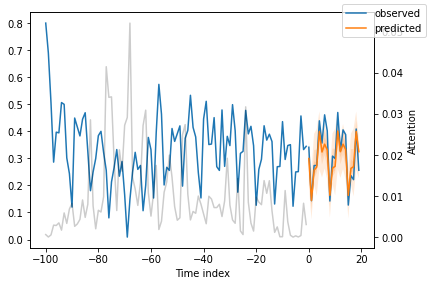

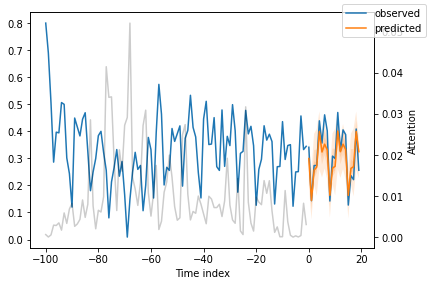

In [ ]:
def plot_prediction(
    self,
    x: Dict[str, torch.Tensor],
    out: Dict[str, torch.Tensor],
    idx: int,
    plot_attention: bool = True,
    add_loss_to_title: bool = False,
    show_future_observed: bool = True,
    ax=None,
) -> plt.Figure:
    """
    Plot actuals vs prediction and attention

    Args:
        x (Dict[str, torch.Tensor]): network input
        out (Dict[str, torch.Tensor]): network output
        idx (int): sample index
        plot_attention: if to plot attention on secondary axis
        add_loss_to_title: if to add loss to title. Default to False.
        show_future_observed: if to show actuals for future. Defaults to True.
        ax: matplotlib axes to plot on

    Returns:
        plt.Figure: matplotlib figure
    """
    # plot prediction as normal
    fig = best_model.plot_prediction(
        x, out, idx=idx, add_loss_to_title=add_loss_to_title, show_future_observed=show_future_observed, ax=ax
    )

    # add attention on secondary axis
    if plot_attention:
        interpretation = self.interpret_output(out)
        ax = fig.axes[0]
        ax2 = ax.twinx()
        ax2.set_ylabel("Attention")
        encoder_length = x["encoder_lengths"][idx]
        ax2.plot(
            torch.arange(-encoder_length, 0),
            interpretation["attention"][idx, :encoder_length].detach().cpu(),
            alpha=0.2,
            color="k",
        )
    fig.tight_layout()
    return fig

raw_predictions, x = best_model.predict(val_dataloader, mode = 'raw', return_x=True)

best_model.plot_prediction( x=x,
    out=raw_predictions,
    idx=0)